# Phase 2: Prepare SwissProt Data and Categorize Proteins

This notebook loads the full SwissProt database and categorizes proteins by their suitability for generating different fragment types.

**Goal**: 
- Load ~570K SwissProt proteins (complete, non-fragments)
- Extract Domain annotations
- Categorize proteins by fragment generation capability
- Prepare protein pools for synthetic fragment generation

**Fragment Types** (excluding terminal_unannotated):
- `terminal_N`: N-terminal truncation (remove domain at start)
- `terminal_C`: C-terminal truncation (remove domain at end)
- `terminal_both`: Both termini truncated (remove domains at both ends)
- `internal_gap`: Internal domain removed (fusion of flanking regions)
- `mixed`: Combination of terminal + internal gaps
- `complete`: Original complete sequence (no fragmentation)

In [14]:
import pandas as pd
import numpy as np
import ijson
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Configuration and Helper Functions

In [15]:
# Path to full SwissProt JSON
SWISSPROT_JSON = "./data/uniprotkb_reviewed_true_2025_11_07.json"

# Fragment types we're targeting (excluding terminal_unannotated)
TARGET_FRAGMENT_TYPES = [
    'terminal_N',
    'terminal_C', 
    'terminal_both',
    'internal_gap',
    'mixed'
]

In [16]:
def extract_domains(features):
    """
    Extract Domain annotations from protein features.
    Returns list of dicts with 'start' and 'end' positions (1-indexed).
    """
    domains = []
    for feature in features:
        if feature.get('type') == 'Domain':
            location = feature.get('location', {})
            start_info = location.get('start', {})
            end_info = location.get('end', {})
            
            # Get start and end positions
            start = start_info.get('value')
            end = end_info.get('value')
            
            if start is not None and end is not None:
                domains.append({
                    'start': int(start),
                    'end': int(end),
                    'description': feature.get('description', '')
                })
    
    return sorted(domains, key=lambda x: x['start'])


def categorize_protein(domains, seq_length):
    """
    Categorize protein by what fragment types it can generate.
    
    Returns list of fragment types this protein can be used for.
    
    Logic:
    - terminal_N: Has domain starting at position 1
    - terminal_C: Has domain ending at seq_length
    - terminal_both: Has domain at position 1 AND domain at seq_length
    - internal_gap: Has domain(s) not touching either terminus
    - mixed: Has both terminal domain(s) AND internal domain(s)
    """
    if not domains:
        return []  # No domains = can't create fragments
    
    fragment_types = []
    
    # Classify each domain
    has_n_terminal = False
    has_c_terminal = False
    has_internal = False
    
    for domain in domains:
        if domain['start'] == 1:
            has_n_terminal = True
        elif domain['end'] == seq_length:
            has_c_terminal = True
        else:
            # Internal domain (doesn't touch either terminus)
            if domain['start'] > 1 and domain['end'] < seq_length:
                has_internal = True
    
    # Determine which fragment types can be generated
    if has_n_terminal:
        fragment_types.append('terminal_N')
    
    if has_c_terminal:
        fragment_types.append('terminal_C')
    
    if has_n_terminal and has_c_terminal:
        fragment_types.append('terminal_both')
    
    if has_internal:
        fragment_types.append('internal_gap')
    
    # Mixed: both terminal (N or C) and internal
    if (has_n_terminal or has_c_terminal) and has_internal:
        fragment_types.append('mixed')
    
    return fragment_types


def is_valid_protein(record):
    """
    Check if protein is valid for fragment generation.
    Must be complete (not a fragment) and have sequence.
    """
    # Check if it's not already a fragment
    protein_desc = record.get('proteinDescription', {})
    if protein_desc.get('flag') == 'Fragment':
        return False
    
    # Must have sequence
    sequence = record.get('sequence', {}).get('value')
    if not sequence:
        return False
    
    # Sequence should be reasonable length (at least 50 aa)
    if len(sequence) < 50:
        return False
    
    return True

## 2. Load and Process SwissProt Database

In [17]:
# Data structures to store protein categorization
protein_pools = defaultdict(list)  # {fragment_type: [protein_data, ...]}
protein_data = []  # All valid proteins with their domain info

# Counters for statistics
stats = {
    'total_processed': 0,
    'valid_proteins': 0,
    'fragments_skipped': 0,
    'no_sequence': 0,
    'too_short': 0,
    'with_domains': 0,
    'without_domains': 0
}

print("Loading SwissProt database...")
print("This may take several minutes...\n")

with open(SWISSPROT_JSON, 'r') as f:
    # Use tqdm for progress bar
    for record in tqdm(ijson.items(f, 'results.item'), desc="Processing proteins"):
        stats['total_processed'] += 1
        
        # Check if protein is valid
        if not is_valid_protein(record):
            protein_desc = record.get('proteinDescription', {})
            if protein_desc.get('flag') == 'Fragment':
                stats['fragments_skipped'] += 1
            elif not record.get('sequence', {}).get('value'):
                stats['no_sequence'] += 1
            else:
                stats['too_short'] += 1
            continue
        
        stats['valid_proteins'] += 1
        
        # Extract protein info
        acc_id = record['primaryAccession']
        sequence = record['sequence']['value']
        seq_length = len(sequence)
        features = record.get('features', [])
        
        # Extract domain annotations
        domains = extract_domains(features)
        
        if domains:
            stats['with_domains'] += 1
        else:
            stats['without_domains'] += 1
        
        # Store protein data
        protein_info = {
            'acc_id': acc_id,
            'sequence': sequence,
            'length': seq_length,
            'domains': domains,
            'n_domains': len(domains)
        }
        protein_data.append(protein_info)
        
        # Categorize protein by fragment generation capability
        fragment_types = categorize_protein(domains, seq_length)
        protein_info['can_generate'] = fragment_types
        
        # Add to appropriate pools
        for ftype in fragment_types:
            protein_pools[ftype].append(protein_info)

print("\n✓ Loading complete!")

Loading SwissProt database...
This may take several minutes...



Processing proteins: 573661it [01:12, 7870.55it/s] 


✓ Loading complete!


## 3. Database Statistics

In [18]:
print("SwissProt Database Statistics:")
print("="*60)
print(f"Total records processed:      {stats['total_processed']:>10,}")
print(f"Valid complete proteins:      {stats['valid_proteins']:>10,}")
print(f"  - With domain annotations:  {stats['with_domains']:>10,}")
print(f"  - Without domain annotations:{stats['without_domains']:>10,}")
print(f"\nSkipped records:")
print(f"  - Already fragments:        {stats['fragments_skipped']:>10,}")
print(f"  - No sequence:              {stats['no_sequence']:>10,}")
print(f"  - Too short (<50 aa):       {stats['too_short']:>10,}")
print("="*60)

SwissProt Database Statistics:
Total records processed:         573,661
Valid complete proteins:         556,177
  - With domain annotations:     132,383
  - Without domain annotations:   423,794

Skipped records:
  - Already fragments:             7,239
  - No sequence:                       0
  - Too short (<50 aa):           10,245


In [19]:
print("\nProtein Pool Sizes by Fragment Type:")
print("="*60)
for ftype in TARGET_FRAGMENT_TYPES:
    count = len(protein_pools[ftype])
    pct = (count / stats['valid_proteins'] * 100) if stats['valid_proteins'] > 0 else 0
    print(f"{ftype:20s}: {count:>8,} proteins ({pct:>5.2f}%)")
print("="*60)
print(f"{'Total protein entries':20s}: {len(protein_data):>8,}")
print("\nNote: A single protein can belong to multiple pools")


Protein Pool Sizes by Fragment Type:
terminal_N          :   10,006 proteins ( 1.80%)
terminal_C          :   16,776 proteins ( 3.02%)
terminal_both       :      591 proteins ( 0.11%)
internal_gap        :  114,329 proteins (20.56%)
mixed               :    8,137 proteins ( 1.46%)
Total protein entries:  556,177

Note: A single protein can belong to multiple pools


## 4. Domain Annotation Analysis

In [20]:
# Analyze domain counts per protein
proteins_with_domains = [p for p in protein_data if p['n_domains'] > 0]
domain_counts = [p['n_domains'] for p in proteins_with_domains]

print("Domain Annotation Statistics:")
print("="*60)
print(f"Proteins with domains:        {len(proteins_with_domains):>10,}")
print(f"Total domain annotations:     {sum(domain_counts):>10,}")
print(f"\nDomains per protein:")
print(f"  Mean:                       {np.mean(domain_counts):>10.2f}")
print(f"  Median:                     {np.median(domain_counts):>10.0f}")
print(f"  Std:                        {np.std(domain_counts):>10.2f}")
print(f"  Min:                        {np.min(domain_counts):>10.0f}")
print(f"  Max:                        {np.max(domain_counts):>10.0f}")
print("="*60)

Domain Annotation Statistics:
Proteins with domains:           132,383
Total domain annotations:        216,391

Domains per protein:
  Mean:                             1.63
  Median:                              1
  Std:                              2.30
  Min:                                 1
  Max:                               285


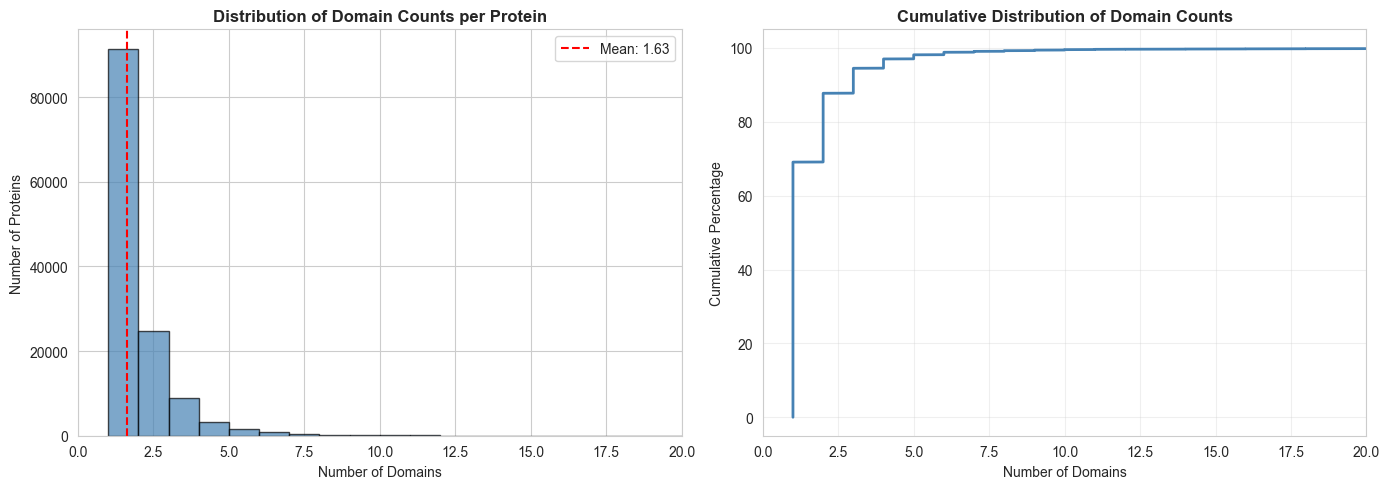

In [21]:
# Plot domain count distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(domain_counts, bins=range(1, min(21, max(domain_counts)+2)), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(domain_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(domain_counts):.2f}')
ax1.set_xlabel('Number of Domains')
ax1.set_ylabel('Number of Proteins')
ax1.set_title('Distribution of Domain Counts per Protein', fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 20)

# Cumulative distribution
sorted_counts = np.sort(domain_counts)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
ax2.plot(sorted_counts, cumulative, color='steelblue', linewidth=2)
ax2.set_xlabel('Number of Domains')
ax2.set_ylabel('Cumulative Percentage')
ax2.set_title('Cumulative Distribution of Domain Counts', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 20)

plt.tight_layout()
plt.savefig('domain_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Analyze proteins by domain count bins
print("\nProteins by Number of Domains:")
print("="*60)
domain_bins = [1, 2, 3, 4, 5, 10, 20, 100]
for i in range(len(domain_bins)):
    if i == 0:
        count = sum(1 for c in domain_counts if c == domain_bins[i])
        print(f"  {domain_bins[i]} domain:     {count:>10,} proteins")
    elif i < len(domain_bins) - 1:
        count = sum(1 for c in domain_counts if domain_bins[i-1] < c <= domain_bins[i])
        print(f"  {domain_bins[i-1]+1}-{domain_bins[i]} domains: {count:>10,} proteins")
    else:
        count = sum(1 for c in domain_counts if c > domain_bins[i-1])
        if count > 0:
            print(f"  >{domain_bins[i-1]} domains:   {count:>10,} proteins")


Proteins by Number of Domains:
  1 domain:         91,454 proteins
  2-2 domains:     24,672 proteins
  3-3 domains:      8,957 proteins
  4-4 domains:      3,341 proteins
  5-5 domains:      1,487 proteins
  6-10 domains:      1,849 proteins
  11-20 domains:        376 proteins
  >20 domains:          247 proteins


## 5. Protein Pool Visualization

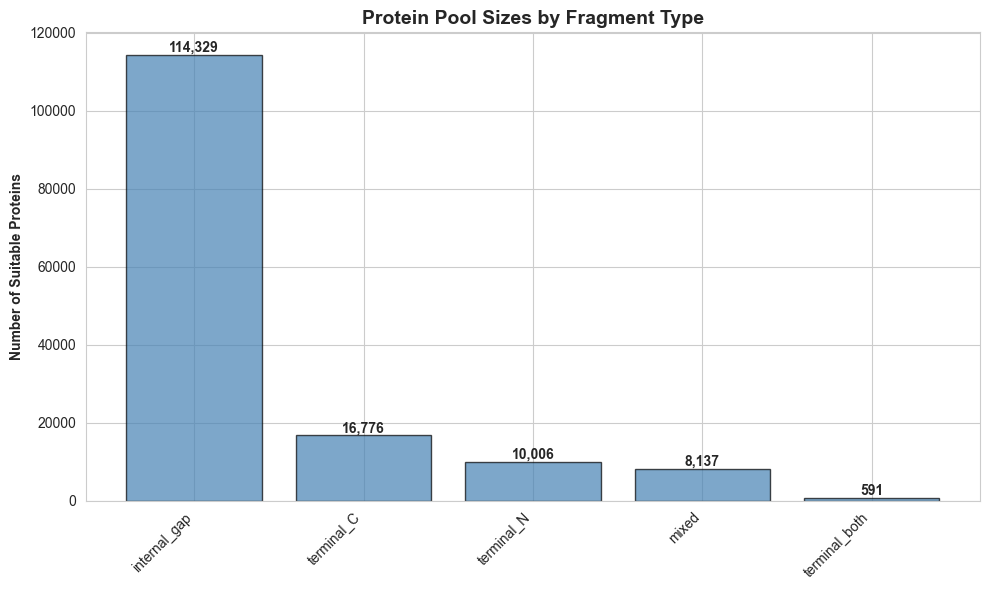

In [23]:
# Bar plot of pool sizes
fig, ax = plt.subplots(figsize=(10, 6))

fragment_types_sorted = sorted(TARGET_FRAGMENT_TYPES, 
                                key=lambda x: len(protein_pools[x]), 
                                reverse=True)
pool_sizes = [len(protein_pools[ft]) for ft in fragment_types_sorted]

bars = ax.bar(range(len(fragment_types_sorted)), pool_sizes, 
              color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(fragment_types_sorted)))
ax.set_xticklabels(fragment_types_sorted, rotation=45, ha='right')
ax.set_ylabel('Number of Suitable Proteins', fontweight='bold')
ax.set_title('Protein Pool Sizes by Fragment Type', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, size) in enumerate(zip(bars, pool_sizes)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('protein_pool_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Processed Data

In [24]:
# Convert protein_data to DataFrame for easier manipulation
# Note: We'll keep domains as JSON string for now
df_proteins = pd.DataFrame([{
    'acc_id': p['acc_id'],
    'length': p['length'],
    'n_domains': p['n_domains'],
    'can_generate': ','.join(p['can_generate']) if p['can_generate'] else '',
    'sequence': p['sequence'],
    'domains': json.dumps(p['domains'])
} for p in protein_data])

print(f"Saving {len(df_proteins):,} protein records...")
df_proteins.to_csv('swissprot_proteins_processed.csv', index=False)
print("✓ Saved to 'swissprot_proteins_processed.csv'")

# Save pool assignments separately for quick lookup
pool_assignments = {}
for ftype in TARGET_FRAGMENT_TYPES:
    pool_assignments[ftype] = [p['acc_id'] for p in protein_pools[ftype]]

with open('protein_pool_assignments.json', 'w') as f:
    json.dump(pool_assignments, f, indent=2)
print("✓ Saved pool assignments to 'protein_pool_assignments.json'")

Saving 556,177 protein records...
✓ Saved to 'swissprot_proteins_processed.csv'
✓ Saved pool assignments to 'protein_pool_assignments.json'


In [25]:
# Create summary statistics
summary = []
for ftype in TARGET_FRAGMENT_TYPES:
    pool = protein_pools[ftype]
    if pool:
        lengths = [p['length'] for p in pool]
        domain_counts = [p['n_domains'] for p in pool]
        summary.append({
            'Fragment Type': ftype,
            'Pool Size': len(pool),
            'Mean Length': np.mean(lengths),
            'Median Length': np.median(lengths),
            'Mean Domains': np.mean(domain_counts),
            'Median Domains': np.median(domain_counts)
        })
    else:
        summary.append({
            'Fragment Type': ftype,
            'Pool Size': 0,
            'Mean Length': 0,
            'Median Length': 0,
            'Mean Domains': 0,
            'Median Domains': 0
        })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values('Pool Size', ascending=False).reset_index(drop=True)

print("\nProtein Pool Summary:")
print("="*90)
print(summary_df.to_string(index=False))

summary_df.to_csv('protein_pool_summary.csv', index=False)
print("\n✓ Summary saved to 'protein_pool_summary.csv'")


Protein Pool Summary:
Fragment Type  Pool Size  Mean Length  Median Length  Mean Domains  Median Domains
 internal_gap     114329   537.974748          406.0      1.732010             1.0
   terminal_C      16776   439.793693          327.0      1.659096             1.0
   terminal_N      10006   361.579352          305.0      1.471617             1.0
        mixed       8137   615.097087          438.0      2.773504             2.0
terminal_both        591   448.785110          424.0      2.737733             2.0

✓ Summary saved to 'protein_pool_summary.csv'


## 7. Validation and Spot Checks

In [26]:
# Randomly sample proteins from each pool for visual inspection
print("Sample Proteins from Each Pool:")
print("="*80)

for ftype in TARGET_FRAGMENT_TYPES:
    pool = protein_pools[ftype]
    if pool:
        # Sample one protein
        sample = pool[0] if len(pool) == 1 else pool[np.random.randint(0, len(pool))]
        print(f"\n{ftype}:")
        print(f"  Accession: {sample['acc_id']}")
        print(f"  Length: {sample['length']} aa")
        print(f"  Domains: {sample['n_domains']}")
        print(f"  Domain positions:")
        for i, dom in enumerate(sample['domains'][:5], 1):  # Show first 5 domains
            print(f"    {i}. [{dom['start']:4d}-{dom['end']:4d}] {dom['description'][:50]}")
        if len(sample['domains']) > 5:
            print(f"    ... and {len(sample['domains']) - 5} more")
    else:
        print(f"\n{ftype}: No proteins available")

Sample Proteins from Each Pool:

terminal_N:
  Accession: P30338
  Length: 104 aa
  Domains: 1
  Domain positions:
    1. [   1-  92] HTH arsR-type

terminal_C:
  Accession: A4WEW4
  Length: 196 aa
  Domains: 1
  Domain positions:
    1. [  34- 196] SIS

terminal_both:
  Accession: Q5WHS8
  Length: 428 aa
  Domains: 3
  Domain positions:
    1. [   1- 158] Obg
    2. [ 159- 329] OBG-type G
    3. [ 350- 428] OCT

internal_gap:
  Accession: C1L1Q9
  Length: 522 aa
  Domains: 1
  Domain positions:
    1. [  10- 277] tr-type G

mixed:
  Accession: B5YKD1
  Length: 425 aa
  Domains: 3
  Domain positions:
    1. [   2- 115] MTTase N-terminal
    2. [ 128- 357] Radical SAM core
    3. [ 360- 425] TRAM


r## 8. Key Findings & Next Steps

### Key Findings:
1. **Protein Pools Created**: Categorized proteins by fragment generation capability
2. **Domain Annotations**: Analyzed distribution and characteristics
3. **Pool Sizes**: Documented availability of suitable proteins for each fragment type

### Files Generated:
- `swissprot_proteins_processed.csv`: All valid proteins with domain info
- `protein_pool_assignments.json`: Protein IDs organized by fragment type
- `protein_pool_summary.csv`: Summary statistics per fragment type

### Next Steps (Phase 3):
1. Load target distribution from Phase 1
2. Implement fragment generation functions for each type:
   - `terminal_N`: Remove domain starting at position 1
   - `terminal_C`: Remove domain ending at sequence end
   - `terminal_both`: Remove domains at both termini
   - `internal_gap`: Remove internal domain, fuse remaining parts
   - `mixed`: Combine terminal + internal removals
3. Create fragment generation logic with length matching
4. Test fragment generation on sample proteins